In [1]:
%matplotlib inline
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import cv

In [2]:
# user config & defined constants
from enum import Enum

class TextDirection(Enum):
	X = 1
	Y = 2

class TextColor(Enum):
	Black = 0
	White = 1

class RectangleType(Enum):
	Rotated = 0
	UnRotated = 1

# User Configuration
TEXT_DIRECTION = TextDirection.Y
TEXT_COLOR = TextColor.Black
CONTOUR_RECTANGLE_TYPE = RectangleType.UnRotated
KERNEL_SIZE = 10
ED_ITERATION = 3
AREA_THRESHOLD = 500
####################

if TEXT_DIRECTION == TextDirection.X:
	KERNEL_SIZE_X = KERNEL_SIZE
	KERNEL_SIZE_Y = 1
else:
	KERNEL_SIZE_X = 1
	KERNEL_SIZE_Y = KERNEL_SIZE

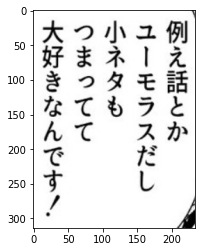

In [3]:
# read
src = cv2.imread('../img/test-1.jpg')
plt.imshow(src)

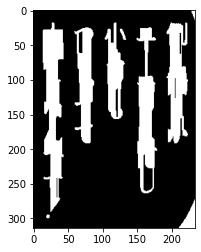

In [4]:
# preprocess
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

if TEXT_COLOR == TextColor.Black:
	binary = cv.reverse(binary)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE_X, KERNEL_SIZE_Y))

dilation = cv2.dilate(binary, kernel, iterations=ED_ITERATION)
erosion = cv2.erode(dilation, kernel, iterations=ED_ITERATION)

plt.imshow(erosion, cmap=plt.cm.gray)

In [5]:
# find contours
# https://blog.csdn.net/huobanjishijian/article/details/63685503
contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

region = []

for i in range(len(contours)):
	cnt = contours[i]
	# 计算该轮廓的面积
	area = cv2.contourArea(cnt) 

	# 面积小的都筛选掉
	if(area < AREA_THRESHOLD):
		continue

	if CONTOUR_RECTANGLE_TYPE == RectangleType.Rotated:
		# 找到最小的矩形，该矩形可能有方向
		rect = cv2.minAreaRect(cnt)
	else:
		rect = cv.minAreaNonRotatedRectangle(cnt)

	# box是四个点的坐标
	box = cv2.boxPoints(rect)
	box = np.int0(box)

	region.append(box)

src = cv2.drawContours(src, region, -1, (0, 255, 0), 2)

text_img = src * 0

for box in region:
	text_img = cv2.fillConvexPoly(text_img, box, (255, 255, 255))


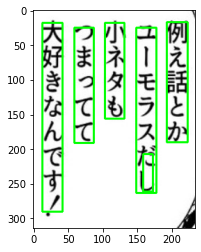

In [6]:
# show src
plt.imshow(src)

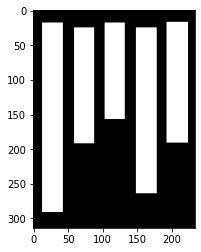

In [7]:
# show text img
plt.imshow(text_img)

In [8]:
# calculate T*
if TEXT_DIRECTION == TextDirection.X:
	D_SIZE = src.shape[0]
else:
	D_SIZE = src.shape[1]

T_star = np.zeros((D_SIZE, 3), dtype=np.float64)
T_star[:, 0] = D_SIZE

for box in region:
	x_1 = box[:, 0].min()
	x_2 = box[:, 0].max()
	y_1 = box[:, 1].min()
	y_2 = box[:, 1].max()
	T_star[x_1:x_2, 0] = np.minimum(T_star[x_1:x_2, 0], y_1)
	T_star[x_1:x_2, 1] = np.maximum(T_star[x_1:x_2, 1], y_2)

if torch.cuda.is_available():
	device = torch.device('cuda')
else:
	device = torch.device('cpu')

T_star = torch.from_numpy(T_star)
T_star = T_star.to(device)


In [9]:
x = torch.tensor(D_SIZE, dtype=torch.float64, device=device)
y = torch.tensor(int(T_star[:,1].min()), dtype=torch.float64, device=device)
l_f = torch.tensor(30, dtype=torch.float64, device=device)
d = torch.tensor(10, dtype=torch.float64, device=device)
c = torch.tensor([0, 2, 11, 19, 26], dtype=torch.float64, device=device)
i = torch.tensor(c.shape[0] - 1, dtype=torch.float64, device=device)

# x = torch.tensor(100, dtype=torch.float64, device=device)
# y = torch.tensor(100, dtype=torch.float64, device=device)
# l_f = torch.tensor(100, dtype=torch.float64, device=device)
# d = torch.tensor(0, dtype=torch.float64, device=device)
# c = torch.tensor([0, 2, 11, 19, 26], dtype=torch.float64, device=device)
# i = torch.tensor(c.shape[0] - 1, dtype=torch.float64, device=device)

def A(x, y, l_f, d, c, i):
	return (x - i * (l_f + d), y, y + (c[1:] - c[:-1]) * l_f)

def A_star(x, y, l_f, d, c, i):
	A_ = A(x, y, l_f, d, c, i)
	A_star_ = torch.zeros(D_SIZE, 2, device=device)
	A_star_[:, 0] = y
	for i in range(c.shape[0] - 1):
		x_ = int(x - i * (l_f + d) + 1)
		x__ = int(x - i * (l_f + d) - l_f + 1)
		A_star_[x__:x_, 1] = A_[2][i]
	return A_star_

In [10]:
def L(A_, T_):
	cap_sum = torch.tensor(0, dtype=torch.float64, device=device)
	cup_sum = torch.tensor(0, dtype=torch.float64, device=device)
	for i in range(D_SIZE):
		if A_[i][1] > T_[i][0] and T_[i][1] > A_[i][0]:
			cap_sum += torch.minimum(A_[i][1] - T_[i][0], T_[i][1] - A_[i][0])
			cup_sum += torch.maximum(A_[i][1] - T_[i][0], T_[i][1] - A_[i][0])
		else:
			cup_sum += A_[i][1] - A_[i][0]
			if (T_[i][1] > T_[i][0]): cup_sum += T_[i][1] - T_[i][0]
	return cap_sum / cup_sum

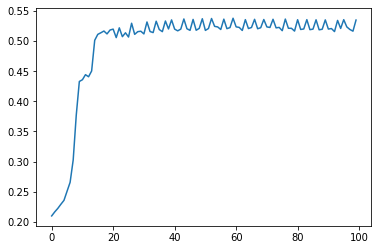

In [11]:
epoch = 100
alpha = 15
eps_x = 1
eps_y = 1
eps_l_f = 1
eps_d = 1

L_list = np.zeros(epoch)

for i in range(epoch):
	L_ = L(A_star(x, y, l_f, d, c, i), T_star)
	L_eps_x = L(A_star(x + eps_x, y, l_f, d, c, i), T_star)
	L_eps_y = L(A_star(x, y + eps_y, l_f, d, c, i), T_star)
	L_eps_l_f = L(A_star(x, y, l_f + eps_l_f, d, c, i), T_star)
	L_eps_d = L(A_star(x, y, l_f, d + eps_d, c, i), T_star)

	x += alpha * (L_eps_x - L_) / eps_x
	y += alpha * (L_eps_y - L_) / eps_y
	l_f += alpha * (L_eps_l_f - L_) / eps_l_f
	d += alpha * (L_eps_d - L_) / eps_d

	L_list[i] = L_
	# print(f'epoch {i}, L: {L_}: x = {x}, y = {y}, l_f = {l_f}, d = {d}')

plt.plot(np.arange(0, epoch, 1), L_list)

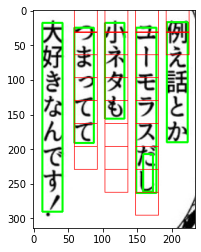

In [12]:
text_arr = c[1:] - c[:-1]
contours_text = []
for i in range(text_arr.shape[0]):
	text_cnt = int(text_arr[i])
	p_x = int(int(x) - i * int(l_f + d))
	p_x_1 = int(p_x - int(l_f))
	for j in range(0, text_cnt):
		p_y = int(y + j * int(l_f))
		p_y_1 = int(p_y + int(l_f))
		contours_text.append([(p_x, p_y), (p_x_1, p_y), (p_x_1, p_y_1), (p_x, p_y_1)])
src = cv2.drawContours(src, np.array(contours_text), -1, (255, 0, 0))

plt.imshow(src)